In [1]:
'''
Adapptation from:
https://github.com/mborysiak

'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
import os

Using TensorFlow backend.


In [2]:

import matplotlib.dates as mdates

def arima_model(series, data_split, params, future_periods, log):
    
    # log transformation of data if user selects log as true
    if log == True:
        series_dates = series.index
        series = pd.Series(np.log(series), index=series.index)
       
    # create training and testing data sets based on user split fraction
    size = int(len(series) * data_split)
    train, test = series[0:size], series[size:len(series)]
    history = [val for val in train]
    predictions = []

    # creates a rolling forecast by testing one value from the test set, and then add that test value
    # to the model training, followed by testing the next test value in the series
    for t in range(len(test)):
        model = ARIMA(history, order=(params[0], params[1], params[2]))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        obs = test[size+ t]
        history.append(obs)
    
    # forecasts future periods past the input testing series based on user input
    future_forecast = model_fit.forecast(future_periods)[0]
    future_dates = [test.index[-1]+i for i in range(1, future_periods+1)]
    test_dates = test.index
    
    # if the data was originally log transformed, the inverse transformation is performed
    if log == True:
        predictions = np.exp(predictions)
        test = pd.Series(np.exp(test), index=test_dates)
        future_forecast = np.exp(future_forecast)
    
    # creates pandas series with datetime index for the predictions and forecast values
    forecast = pd.Series(future_forecast, index=future_dates)
    predictions = pd.Series(predictions, index=test_dates)
    
    # generates plots to compare the predictions for out-of-sample data to the actual test values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(predictions, c='red')
    plt.plot(test)
    plt.show()
    
    # calculates root mean squared errors (RMSEs) for the out-of-sample predictions
    error = np.sqrt(mean_squared_error(predictions, test))
    print('Test RMSE: %.3f' % error)
    
    return predictions, test, future_forecast

Let us generate a time series


,a,b,c
0,-1.871335,-1.412423,1.264238
1,-3.161238,-1.685560,3.132808
2,-2.641209,-1.231883,0.644495
3,-2.365284,-2.033813,-1.248875
4,-2.733350,-0.740102,1.360290


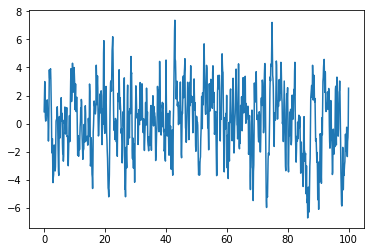

In [3]:


from statsmodels.tsa.arima_process import arma_generate_sample

##number of point of the time series
nsample = 1000
## simulate a simple sinusoidal function
x1 = np.linspace(0, 100, nsample)

#np.random.seed(12345)
arparams = np.array([.5, .2])
maparams = np.array([1, 1,])
arparams = np.r_[1, -arparams]
maparam = np.r_[1, maparams]

y = arma_generate_sample(arparams, maparams, nsample)
a= arma_generate_sample(arparams, maparams, nsample)
b=arma_generate_sample(arparams, maparams, nsample)
c=arma_generate_sample(arparams, maparams, nsample)
fig, ax = plt.subplots()
ax.plot(x1, y, label="Data") 
index_ = [i for i in range(0,nsample)]

y=pd.Series(y,index=index_)
additional_series =pd.DataFrame({'a':a,'b':b,'c':c},index=index_)
additional_series.head()

Let us fit an ARIMA and predict

C:\Users\IB\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


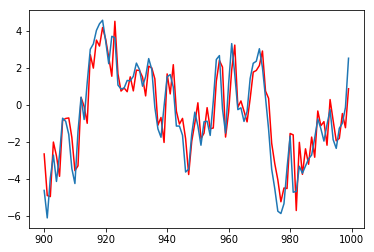

Test RMSE: 1.044


In [4]:
data_split = 0.9
p = 2
d = 0
q = 2
params = [p, d, q]
future_periods = 12
log = False

predictions, test, forecast = arima_model(y, data_split, params, future_periods, log)

Let us fit an LSTM and predict

In [5]:
def lstm_model(data_series, look_back, split, transforms, lstm_params):
    
    # creating the training and testing datasets
    X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset(data_series, look_back, split, transforms)

    # training the model
    model = Sequential()
    model.add(LSTM(lstm_params[0], input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=lstm_params[1], batch_size=1, verbose=lstm_params[2])
    
    # making predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # inverse transforming results
    train_predict, y_train, test_predict, y_test =inverse_transforms(
        train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler)
    
    # plot of predictions and actual values
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(y_test)
    plt.plot(test_predict, color='red')
    plt.show()
    
    # calculating RMSE metrics
    train_error = np.sqrt(mean_squared_error(train_predict, y_train))
    print('Train RMSE: %.3f' % train_error )
    test_error = np.sqrt(mean_squared_error(test_predict, y_test))
    print('Test RMSE: %.3f' % test_error)
    
    return train_predict, y_train, test_predict, y_test, train_error, test_error

In [6]:

def inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler):
    
    # inverse 0 to 1 scaling
    train_predict = pd.Series(scaler.inverse_transform(train_predict.reshape(-1,1))[:,0], index=train_dates)
    y_train = pd.Series(scaler.inverse_transform(y_train.reshape(-1, 1))[:,0], index=train_dates)

    test_predict = pd.Series(scaler.inverse_transform(test_predict.reshape(-1, 1))[:,0], index=test_dates)
    y_test = pd.Series(scaler.inverse_transform(y_test.reshape(-1, 1))[:,0], index=test_dates)
    
    # reversing differencing if log transformed as well
    if (transforms[1] == True) & (transforms[0] == True):
        train_predict = pd.Series(train_predict + np.log(data_series.shift(1)), index=train_dates).dropna()
        y_train = pd.Series(y_train + np.log(data_series.shift(1)), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + np.log(data_series.shift(1)), index=test_dates).dropna()
        y_test = pd.Series(y_test + np.log(data_series.shift(1)), index=test_dates).dropna()
    
    # reversing differencing if no log transform
    elif transforms[1] == True:
        train_predict = pd.Series(train_predict + data_series.shift(1), index=train_dates).dropna()
        y_train = pd.Series(y_train + data_series.shift(1), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + data_series.shift(1), index=test_dates).dropna()
        y_test = pd.Series(y_test + data_series.shift(1), index=test_dates).dropna()
      
    # reversing log transformation
    if transforms[0] == True:
        train_predict = pd.Series(np.exp(train_predict), index=train_dates)
        y_train = pd.Series(np.exp(y_train), index=train_dates)

        test_predict = pd.Series(np.exp(test_predict), index=test_dates)
        y_test = pd.Series(np.exp(y_test), index=test_dates)
        
    return train_predict, y_train, test_predict, y_test

In [7]:
def create_dataset(data_series, look_back, split_frac, transforms):
    
    # log transforming that data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(np.log(data_series), index=dates)
    
    # differencing data, if necessary
    if transforms[1] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()

    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
        
    df = df.dropna()
    
    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]
    
    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index

    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], 1, look_back))
    X_test = np.reshape(X_test, (X_test.shape[0],1, look_back))
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

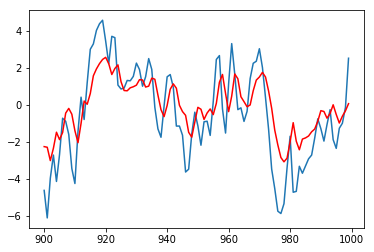

Train RMSE: 1.529
Test RMSE: 1.643
Nodes:  3 ,Epoches : 1 Train error : 1.5294652356467247 Test error : 1.642699195028548


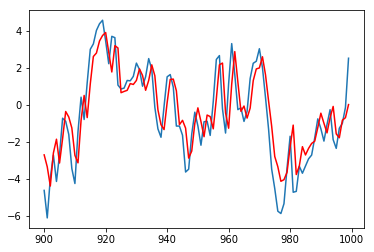

Train RMSE: 1.245
Test RMSE: 1.294
Nodes:  3 ,Epoches : 5 Train error : 1.2447935162618018 Test error : 1.293920822931261


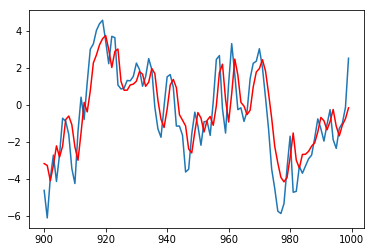

Train RMSE: 1.348
Test RMSE: 1.383
Nodes:  3 ,Epoches : 10 Train error : 1.3481856595697068 Test error : 1.3833167210005024


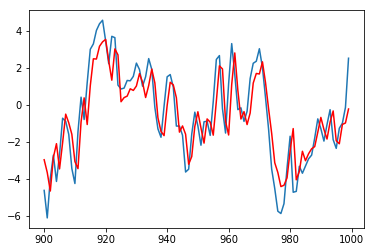

Train RMSE: 1.247
Test RMSE: 1.265
Nodes:  3 ,Epoches : 20 Train error : 1.2472505295848142 Test error : 1.265008815667531


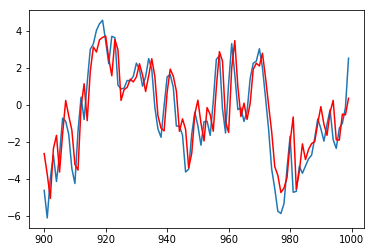

Train RMSE: 1.198
Test RMSE: 1.251
Nodes:  3 ,Epoches : 50 Train error : 1.1976704128143942 Test error : 1.250924461127864


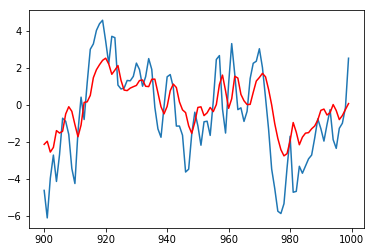

Train RMSE: 1.605
Test RMSE: 1.749
Nodes:  6 ,Epoches : 1 Train error : 1.605456500108429 Test error : 1.7494144382383652


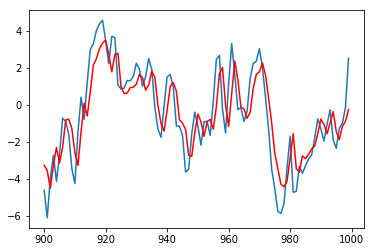

Train RMSE: 1.320
Test RMSE: 1.337
Nodes:  6 ,Epoches : 5 Train error : 1.319766253992687 Test error : 1.3369178801414758


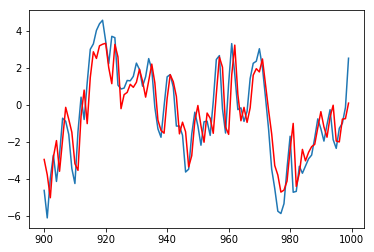

Train RMSE: 1.202
Test RMSE: 1.234
Nodes:  6 ,Epoches : 10 Train error : 1.2017279915843442 Test error : 1.234127912618986


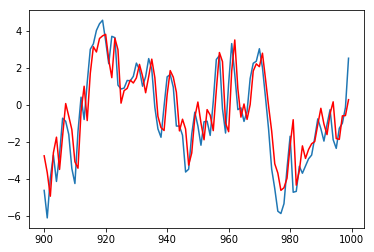

Train RMSE: 1.196
Test RMSE: 1.246
Nodes:  6 ,Epoches : 20 Train error : 1.1959539392759204 Test error : 1.2456200770479466


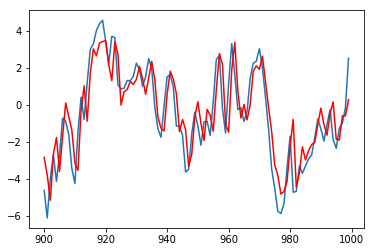

Train RMSE: 1.190
Test RMSE: 1.237
Nodes:  6 ,Epoches : 50 Train error : 1.190123850058495 Test error : 1.2366314711364057


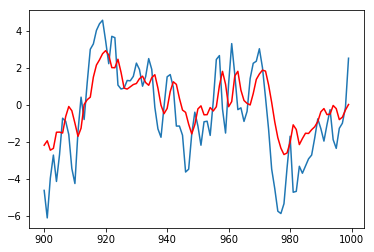

Train RMSE: 1.643
Test RMSE: 1.780
Nodes:  9 ,Epoches : 1 Train error : 1.6428374939504828 Test error : 1.779652569953659


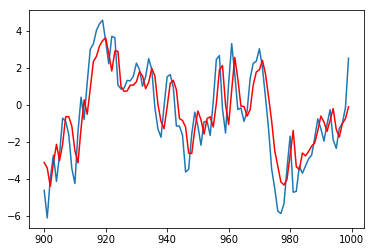

Train RMSE: 1.296
Test RMSE: 1.331
Nodes:  9 ,Epoches : 5 Train error : 1.2963310395824847 Test error : 1.3310617681256949


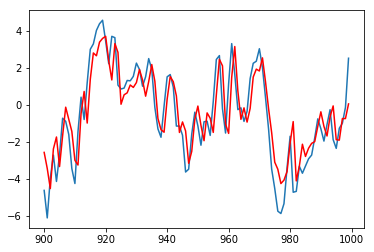

Train RMSE: 1.208
Test RMSE: 1.260
Nodes:  9 ,Epoches : 10 Train error : 1.2081687902146527 Test error : 1.259931381060725


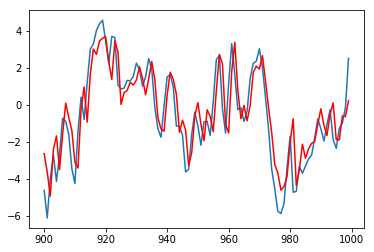

Train RMSE: 1.193
Test RMSE: 1.246
Nodes:  9 ,Epoches : 20 Train error : 1.1932095111734247 Test error : 1.2458180463446042


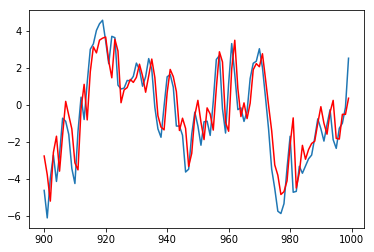

Train RMSE: 1.194
Test RMSE: 1.246
Nodes:  9 ,Epoches : 50 Train error : 1.193611123088208 Test error : 1.2463827973401282
train_errors:  [1.5294652356467247, 1.2447935162618018, 1.3481856595697068, 1.2472505295848142, 1.1976704128143942, 1.605456500108429, 1.319766253992687, 1.2017279915843442, 1.1959539392759204, 1.190123850058495, 1.6428374939504828, 1.2963310395824847, 1.2081687902146527, 1.1932095111734247, 1.193611123088208]
test_errors:  [1.642699195028548, 1.293920822931261, 1.3833167210005024, 1.265008815667531, 1.250924461127864, 1.7494144382383652, 1.3369178801414758, 1.234127912618986, 1.2456200770479466, 1.2366314711364057, 1.779652569953659, 1.3310617681256949, 1.259931381060725, 1.2458180463446042, 1.2463827973401282]


In [8]:
look_back = 2
split = 0.9
log = False
difference = False
transforms = [log, difference]

n_nodes =   [3,6,9]        #[3,6,9,12,15]
n_epochs = [1,5,10,20,50]    #[1,5,10,20,50,100,150,200,300,500,1000]
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least

train_errors =[]
test_errors =[]

for nodes in n_nodes:
    for epochs in n_epochs:
        lstm_params = [nodes, epochs, verbose]
        train_predict, y_train, test_predict, y_test,train_error, test_error = lstm_model(y, look_back, split, transforms, lstm_params)
        train_errors.append(train_error)
        test_errors.append(test_error)
        print('Nodes: ',nodes, ',Epoches :', epochs, 'Train error :' ,train_error, 'Test error :' ,test_error  )

print('train_errors: ',train_errors)
print('test_errors: ',test_errors)


        

In [9]:
def lstm_model2(data_series, look_back, split, transforms, lstm_params,additional_series):
    
    # creating the training and testing datasets
    X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset2(
        data_series, look_back, split, transforms,additional_series)

    # training the model
    model = Sequential()
    model.add(LSTM(lstm_params[0], input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=lstm_params[1], batch_size=1, verbose=lstm_params[2])
    
    # making predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # inverse transforming results
    train_predict, y_train, test_predict, y_test =inverse_transforms(
        train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler)
    
    # plot of predictions and actual values
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(y_test)
    plt.plot(test_predict, color='red')
    plt.show()
    
    # calculating RMSE metrics
    train_error = np.sqrt(mean_squared_error(train_predict, y_train))
    print('Train RMSE: %.3f' % train_error)
    test_error = np.sqrt(mean_squared_error(test_predict, y_test))
    print('Test RMSE: %.3f' % test_error)
    
    return train_predict, y_train, test_predict, y_test, train_error, test_error

In [10]:
def create_dataset2(data_series, look_back, split_frac, transforms, additional_series):
    
    # log transforming that data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(np.log(data_series), index=dates)
    
    # differencing data, if necessary
    if transforms[1] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()
    
    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    #scaled_additional = scaler.fit_transform(additional_series)
    #scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    #data_additional_series =pd.DataFrame(scaled_additional[:,:], index=dates, columns=additional_series.columns)
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
        for col in additional_series.columns:
            label = col+ '_'+''.join(['t-', str(i)])
            df[label] = pd.Series(scaler.transform(additional_series[col].values.reshape(-1, 1))[:,0], index =dates).shift(i)

        
    df = df.dropna()
    
    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]

    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index

    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0],X_train.shape[1], 1))
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

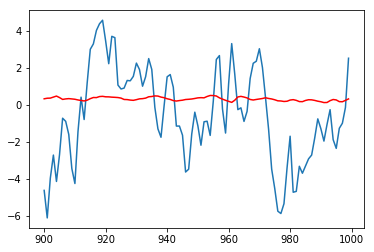

Train RMSE: 2.253
Test RMSE: 2.658
Nodes:  3 ,Epoches : 1 Train error : 2.2531087776581935 Test error : 2.6580907653306847


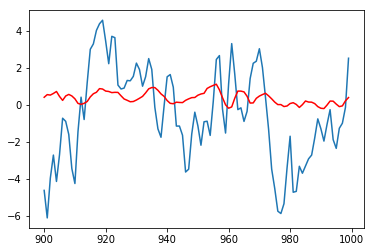

Train RMSE: 2.206
Test RMSE: 2.608
Nodes:  3 ,Epoches : 5 Train error : 2.205948769834523 Test error : 2.608387344178572


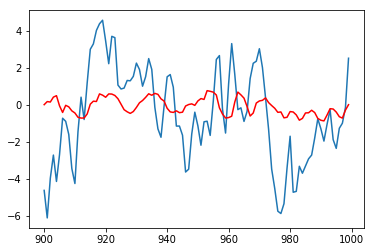

Train RMSE: 2.220
Test RMSE: 2.476
Nodes:  3 ,Epoches : 10 Train error : 2.2203747030838263 Test error : 2.4760177425025063


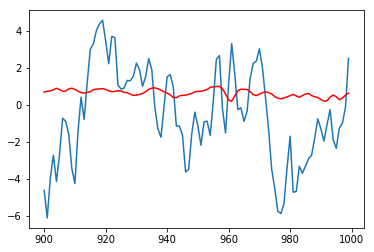

Train RMSE: 2.262
Test RMSE: 2.765
Nodes:  3 ,Epoches : 20 Train error : 2.2616667528881744 Test error : 2.7649939379749315


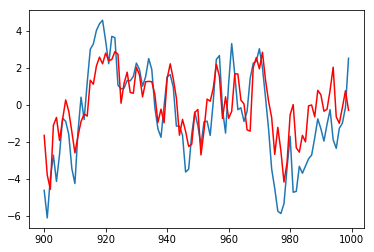

Train RMSE: 1.554
Test RMSE: 1.649
Nodes:  3 ,Epoches : 50 Train error : 1.5544809450579262 Test error : 1.6490947305203036


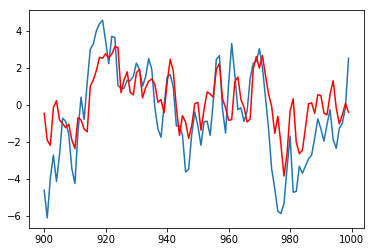

Train RMSE: 1.528
Test RMSE: 1.846
Nodes:  3 ,Epoches : 100 Train error : 1.5275971666667256 Test error : 1.8456273914414765


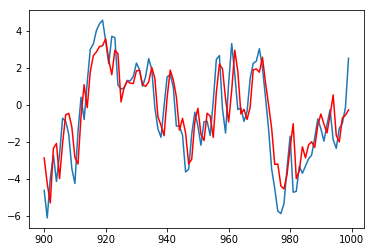

Train RMSE: 1.223
Test RMSE: 1.275
Nodes:  3 ,Epoches : 200 Train error : 1.2232922498740317 Test error : 1.2753462821689558


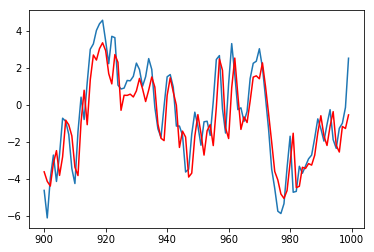

Train RMSE: 1.328
Test RMSE: 1.296
Nodes:  3 ,Epoches : 300 Train error : 1.3281700083862482 Test error : 1.2958360704839507


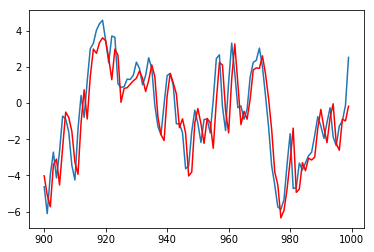

Train RMSE: 1.232
Test RMSE: 1.282
Nodes:  3 ,Epoches : 400 Train error : 1.231812508649308 Test error : 1.2817387667205795


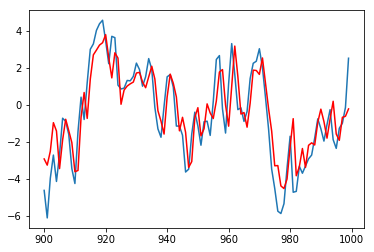

Train RMSE: 1.220
Test RMSE: 1.292
Nodes:  3 ,Epoches : 500 Train error : 1.2204493996294485 Test error : 1.2918032928489123


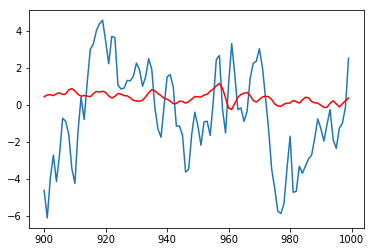

Train RMSE: 2.245
Test RMSE: 2.652
Nodes:  6 ,Epoches : 1 Train error : 2.2451282217664703 Test error : 2.651910413483927


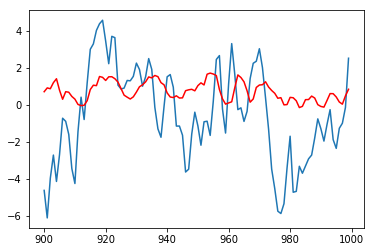

Train RMSE: 2.213
Test RMSE: 2.718
Nodes:  6 ,Epoches : 5 Train error : 2.2130140592211376 Test error : 2.7175961761600176


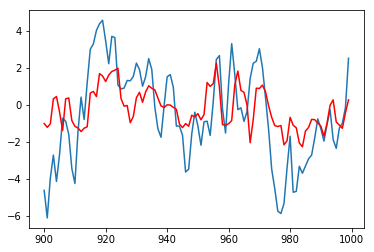

Train RMSE: 1.883
Test RMSE: 2.060
Nodes:  6 ,Epoches : 10 Train error : 1.8834923070949905 Test error : 2.0603195297161228


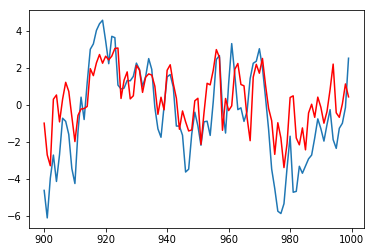

Train RMSE: 1.671
Test RMSE: 1.869
Nodes:  6 ,Epoches : 20 Train error : 1.6706851690385227 Test error : 1.8690037233190224


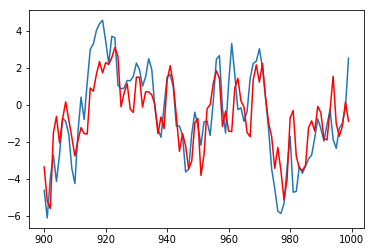

Train RMSE: 1.671
Test RMSE: 1.548
Nodes:  6 ,Epoches : 50 Train error : 1.6705598561818056 Test error : 1.5475974299896407


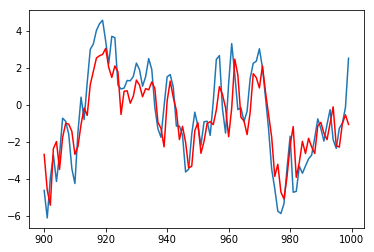

Train RMSE: 1.388
Test RMSE: 1.338
Nodes:  6 ,Epoches : 100 Train error : 1.3878302031535912 Test error : 1.3376083623986685


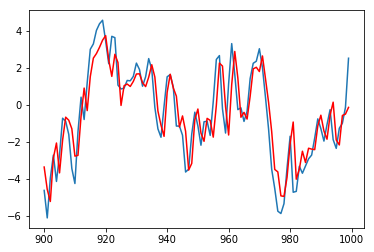

Train RMSE: 1.222
Test RMSE: 1.226
Nodes:  6 ,Epoches : 200 Train error : 1.2219601358916254 Test error : 1.2259640003741268


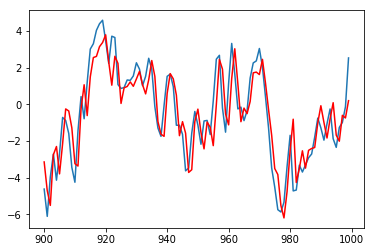

Train RMSE: 1.182
Test RMSE: 1.250
Nodes:  6 ,Epoches : 300 Train error : 1.1820464002004505 Test error : 1.2504262016016638


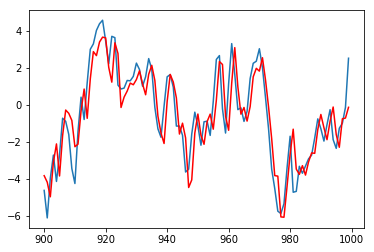

Train RMSE: 1.197
Test RMSE: 1.238
Nodes:  6 ,Epoches : 400 Train error : 1.1971322883035582 Test error : 1.2382409642016756


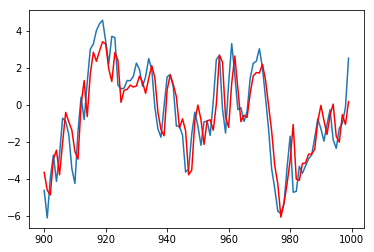

Train RMSE: 1.184
Test RMSE: 1.219
Nodes:  6 ,Epoches : 500 Train error : 1.1841621110651257 Test error : 1.2191659366633227


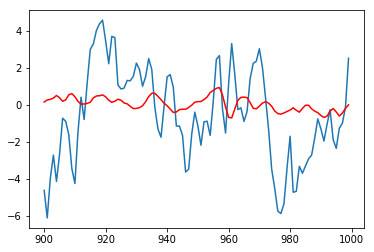

Train RMSE: 2.274
Test RMSE: 2.545
Nodes:  9 ,Epoches : 1 Train error : 2.274466878962689 Test error : 2.545181781685964


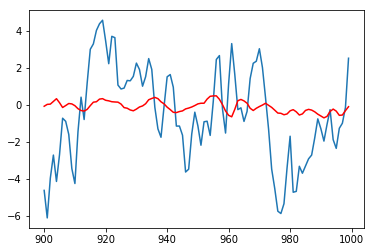

Train RMSE: 2.268
Test RMSE: 2.506
Nodes:  9 ,Epoches : 5 Train error : 2.268278523900789 Test error : 2.505921909275899


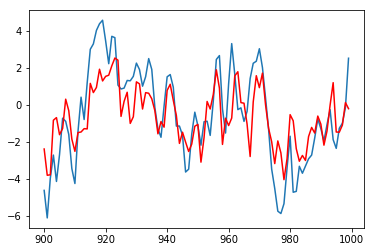

Train RMSE: 1.727
Test RMSE: 1.635
Nodes:  9 ,Epoches : 10 Train error : 1.7269483332364384 Test error : 1.6350538582728693


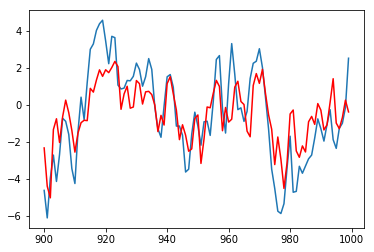

Train RMSE: 1.640
Test RMSE: 1.592
Nodes:  9 ,Epoches : 20 Train error : 1.6399292422267577 Test error : 1.5920702075778168


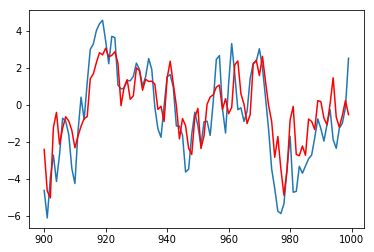

Train RMSE: 1.436
Test RMSE: 1.499
Nodes:  9 ,Epoches : 50 Train error : 1.4364291315513456 Test error : 1.498967783653921


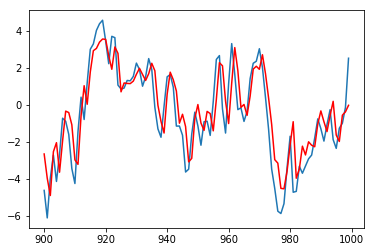

Train RMSE: 1.233
Test RMSE: 1.284
Nodes:  9 ,Epoches : 100 Train error : 1.2334250218565699 Test error : 1.2836624876972633


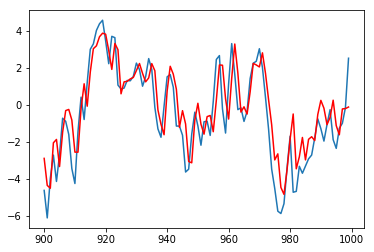

Train RMSE: 1.233
Test RMSE: 1.329
Nodes:  9 ,Epoches : 200 Train error : 1.2328827066790664 Test error : 1.3291352467771167


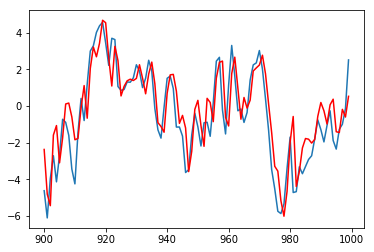

Train RMSE: 1.142
Test RMSE: 1.311
Nodes:  9 ,Epoches : 300 Train error : 1.1416454722016565 Test error : 1.311122825554739


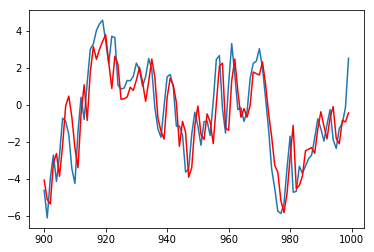

Train RMSE: 1.164
Test RMSE: 1.290
Nodes:  9 ,Epoches : 400 Train error : 1.1639148270403894 Test error : 1.290074245430326


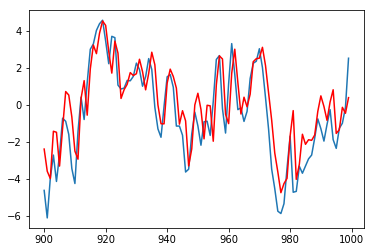

Train RMSE: 1.200
Test RMSE: 1.417
Nodes:  9 ,Epoches : 500 Train error : 1.1997241258168412 Test error : 1.4165025478106377
train_errors:  [2.2531087776581935, 2.205948769834523, 2.2203747030838263, 2.2616667528881744, 1.5544809450579262, 1.5275971666667256, 1.2232922498740317, 1.3281700083862482, 1.231812508649308, 1.2204493996294485, 2.2451282217664703, 2.2130140592211376, 1.8834923070949905, 1.6706851690385227, 1.6705598561818056, 1.3878302031535912, 1.2219601358916254, 1.1820464002004505, 1.1971322883035582, 1.1841621110651257, 2.274466878962689, 2.268278523900789, 1.7269483332364384, 1.6399292422267577, 1.4364291315513456, 1.2334250218565699, 1.2328827066790664, 1.1416454722016565, 1.1639148270403894, 1.1997241258168412]
test_errors:  [2.6580907653306847, 2.608387344178572, 2.4760177425025063, 2.7649939379749315, 1.6490947305203036, 1.8456273914414765, 1.2753462821689558, 1.2958360704839507, 1.2817387667205795, 1.2918032928489123, 2.651910413483927, 2.7175961761600176, 2.06031952

In [12]:
look_back = 2
split = 0.9
log = False
difference = False
transforms = [log, difference]

n_nodes = [3,6,9]
n_epochs = [1,5,10,20,50,100,200,300,400,500]
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least

train_errors2 =[]
test_errors2 =[]

for nodes in n_nodes:
    for epochs in n_epochs:
        lstm_params = [nodes, epochs, verbose]
        train_predict, y_train, test_predict, y_test,train_error, test_error = lstm_model2(y, look_back, split, transforms, lstm_params,additional_series)
        train_errors2.append(train_error)
        test_errors2.append(test_error)
        print('Nodes: ',nodes, ',Epoches :', epochs, 'Train error :' ,train_error, 'Test error :' ,test_error  )
        
print('train_errors: ',train_errors2)
print('test_errors: ',test_errors2)
        
        